# Import Libraries

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from keras import models, layers, optimizers, losses
from sklearn.linear_model import LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier

# Obtain and Scrub Data

Read data into pandas df

In [35]:
df = pd.read_csv('Excel/scrubbed_df.csv')
print(df.shape)
df.head()

(169, 10)


,total_fertility_rate,replacement,GDP per capita (constant 2010 US$),GDP per capita growth (annual %),General government final consumption expenditure (% of GDP),"Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)","Personal remittances, received (% of GDP)",Population density (people per sq. km of land area),"Self-employed, total (% of total employment) (modeled ILO estimate)",Urban population (% of total population)
0,1.8324,0,26630.205281,1.521780,16.687991,52.654202,1.836798,588.027778,40.922914,43.546
1,1.7269,0,41420.483032,0.225275,13.278419,52.481998,4.847161,135.609110,3.902000,86.789
2,5.0200,1,571.466641,0.549628,13.123956,21.771000,4.337765,56.937760,82.250000,25.754
3,2.6646,1,4710.583772,-1.130692,18.602840,14.556000,1.054191,17.730075,31.554001,73.189
4,1.8881,0,5879.992654,1.366684,10.827243,63.130001,2.653967,120.234317,67.792000,56.031


Confirm that data has already been scrubbed in obtain_scrub notebook

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column                                                                                           Non-Null Count  Dtype  
---  ------                                                                                           --------------  -----  
 0   total_fertility_rate                                                                             169 non-null    float64
 1   replacement                                                                                      169 non-null    int64  
 2   GDP per capita (constant 2010 US$)                                                               169 non-null    float64
 3   GDP per capita growth (annual %)                                                                 169 non-null    float64
 4   General government final consumption expenditure (% of GDP)                                      169 non-null    float64
 5   Labor fo

# EDA

Calculate class frequencies

In [37]:
df['replacement'].value_counts()

1    93
0    76
Name: replacement, dtype: int64

Calculate class weights

In [38]:
df['replacement'].mean()

0.5502958579881657

Create countplot of class weights

Text(0.5, 1.0, 'Fertility Replacement Class Balance')

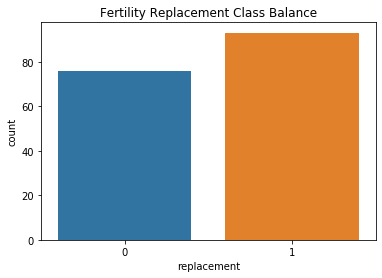

In [39]:
fig, ax = plt.subplots()
sns.countplot(x='replacement', data=df, ax=ax)
ax.set_title('Fertility Replacement Class Balance')

Plot distributions of features

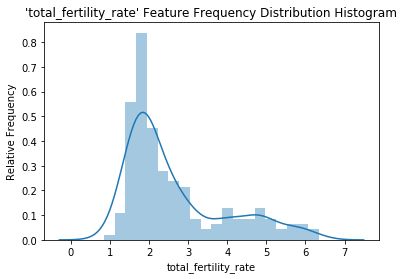

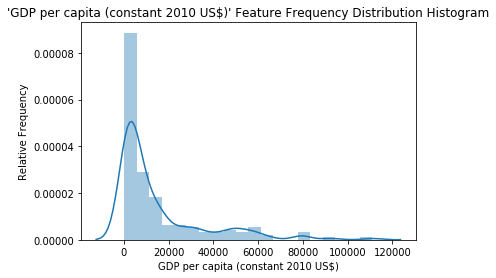

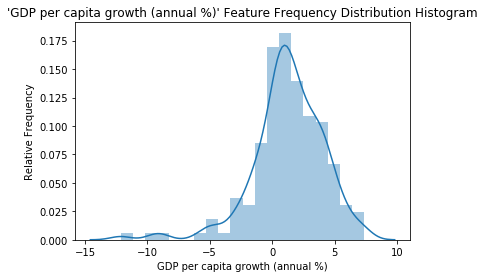

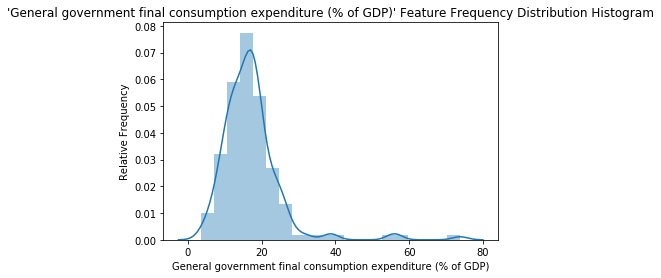

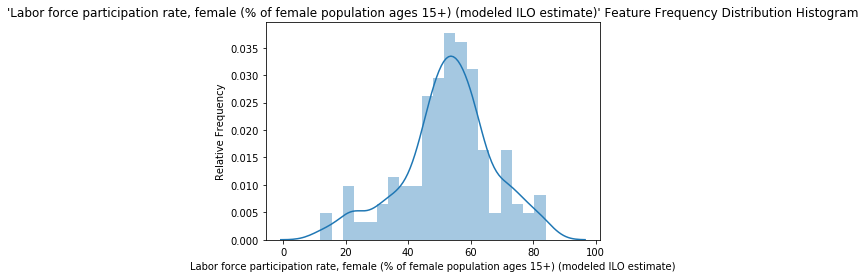

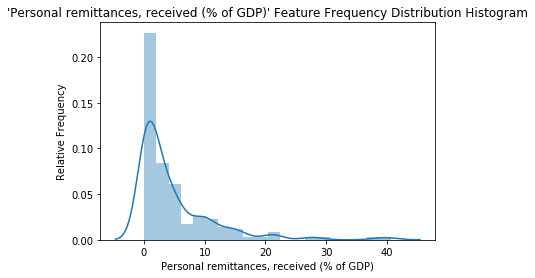

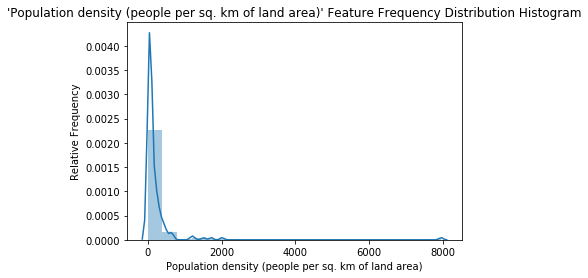

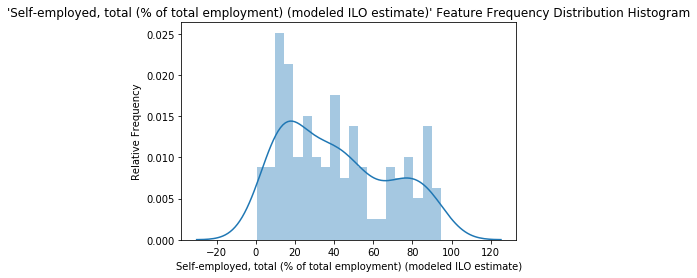

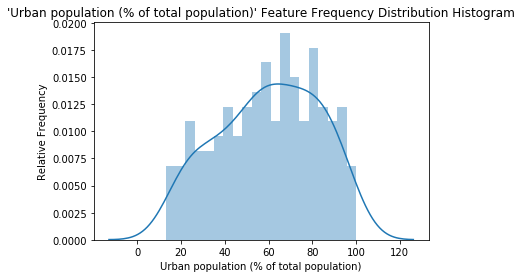

In [40]:
histogram_columns = list(df.columns)
histogram_columns.remove('replacement')
for column in histogram_columns:
    fig, ax = plt.subplots()
    sns.distplot(df[column], bins=20, ax=ax)
    ax.set_ylabel('Relative Frequency')
    ax.set_title(f"'{column}' Feature Frequency Distribution Histogram")


View feature correlations

Text(0.5, 1, 'Fertility Dataset Correlation Heatmap')

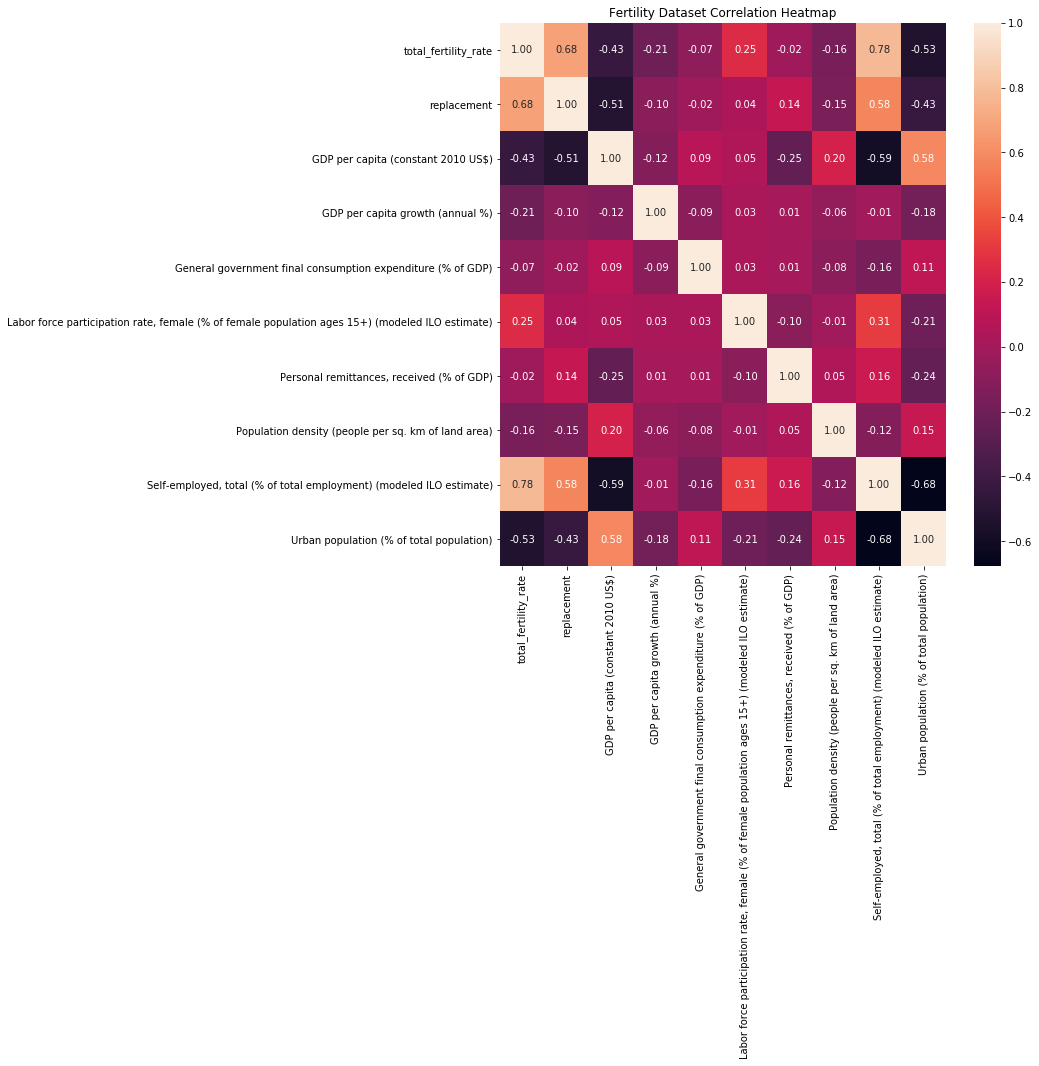

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt='.2f')
ax.set_title('Fertility Dataset Correlation Heatmap')

# Modeling

Create x and y variables

In [42]:
x_vars = list(df.columns)
x_vars.remove('total_fertility_rate')
x_vars.remove('replacement')
x=df[x_vars]
y=df['replacement']

Perform train test split

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=52)

Standard Scale data

In [44]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_vars)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_vars)

Upsample minority class with smote

In [45]:
sm = SMOTE(random_state=51)
x_train, y_train = sm.fit_sample(x_train, y_train)
print(x_train.shape)
y_train.value_counts()

(138, 8)


1    69
0    69
Name: replacement, dtype: int64

Build Dummy Classifier model

In [46]:
dc = DummyClassifier(strategy='stratified', random_state=91)
dc.fit(x_train, y_train)
y_test_pred_dc = dc.predict(x_test)
y_train_pred_dc = dc.predict(x_train)
print('Train f1 score', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 score', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy', accuracy_score(y_test, y_test_pred_dc))

Train f1 score 0.5147058823529412
Train Accuracy 0.5217391304347826
Test f1 score 0.5833333333333334
Test Accuracy 0.5348837209302325


Create Dummy Classifier Confusion Matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

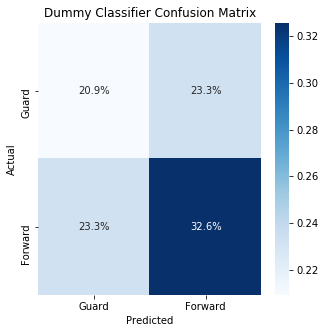

In [47]:
dc_cm = confusion_matrix(y_test, y_test_pred_dc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(dc_cm/np.sum(dc_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Dummy Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch knn model

In [48]:
knn_param_grid = {'n_neighbors': range(1,21), 'weights':['uniform', 'distance']}
knn_gs_model = KNeighborsClassifier()
knn_gs = GridSearchCV(knn_gs_model, knn_param_grid, scoring='f1', n_jobs=-1, cv=10, verbose=1)
knn_gs.fit(x_train, y_train)
print('Best params:', knn_gs.best_params_)
print('Best estimator:', knn_gs.best_estimator_)
print('Best score: ', knn_gs.best_score_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s


Best params: {'n_neighbors': 4, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')
Best score:  0.7867932067932067


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.8s finished


Build knn model

In [49]:
knn =  KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(x_train, y_train)
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)
print('Train f1 score', f1_score(y_train, y_train_pred_knn))
print('Train Accuracy', accuracy_score(y_train, y_train_pred_knn))
print('Test f1 score', f1_score(y_test, y_test_pred_knn))
print('Test Accuracy', accuracy_score(y_test, y_test_pred_knn))

Train f1 score 1.0
Train Accuracy 1.0
Test f1 score 0.7272727272727272
Test Accuracy 0.7209302325581395


Create knn confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

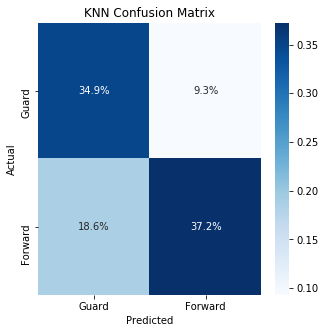

In [50]:
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(knn_cm/np.sum(knn_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('KNN Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch adaboost params

In [51]:
ab_param_grid = {'learning_rate': [x/100 for x in range(10,31)]}
ab_gs_model = AdaBoostClassifier()
ab_gs = GridSearchCV(ab_gs_model, ab_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)
print('Best params:', ab_gs.best_params_)
print('Best estimator:', ab_gs.best_estimator_)
print('Best score: ', ab_gs.best_score_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s


Best params: {'learning_rate': 0.23}
Best estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.23,
                   n_estimators=50, random_state=None)
Best score:  0.8687545787545787


[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    6.2s finished


Build adaboost model

In [52]:
ab =  AdaBoostClassifier(learning_rate = .23)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Train f1 score', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 score', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy', accuracy_score(y_test, y_test_pred_ab))

Train f1 score 0.9473684210526315
Train Accuracy 0.9492753623188406
Test f1 score 0.7999999999999999
Test Accuracy 0.7906976744186046


Build adaboost confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

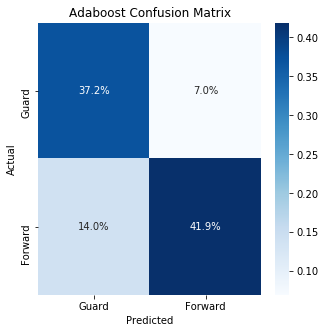

In [53]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Adaboost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

[Text(0, 0, 'GDP per capita (constant 2010 US$)'),
 Text(0, 0, 'GDP per capita growth (annual %)'),
 Text(0, 0, 'General government final consumption expenditure (% of GDP)'),
 Text(0, 0, 'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)'),
 Text(0, 0, 'Personal remittances, received (% of GDP)'),
 Text(0, 0, 'Population density (people per sq. km of land area)'),
 Text(0, 0, 'Self-employed, total (% of total employment) (modeled ILO estimate)'),
 Text(0, 0, 'Urban population (% of total population)')]

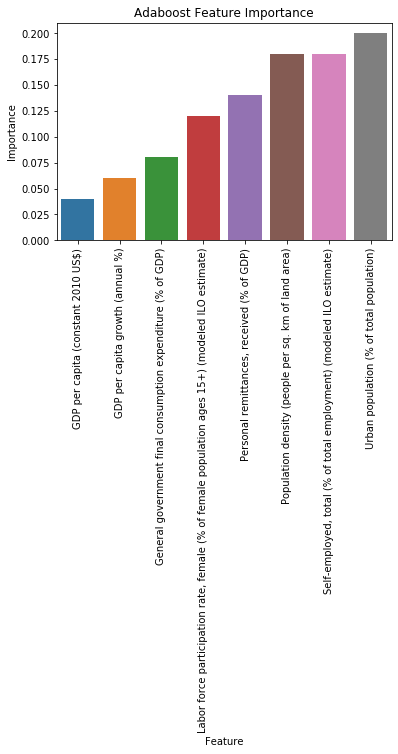

In [54]:
ab_df = pd.DataFrame(ab.feature_importances_).T
ab_df.columns = x_vars
ab_df = ab_df.T.reset_index()
ab_df.columns=['Feature', 'Importance']
ab_df = ab_df.sort_values(by='Importance')
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Importance', data=ab_df, ax=ax)
ax.set_title('Adaboost Feature Importance')
ax.set_xticklabels(x_vars, rotation=90)

In [55]:
ab_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,GDP per capita (constant 2010 US$),0.20
1,GDP per capita growth (annual %),0.18
5,Population density (people per sq. km of land ...,0.18
2,General government final consumption expenditu...,0.14
3,"Labor force participation rate, female (% of f...",0.12
4,"Personal remittances, received (% of GDP)",0.08
7,Urban population (% of total population),0.06
6,"Self-employed, total (% of total employment) (...",0.04


Define Neural Network

In [71]:
def nn(nodes, drop_prop):
    nn = models.Sequential()
    nn.add(layers.Dense(nodes, activation = 'sigmoid'))
    nn.add(layers.Dropout(drop_prop))
    nn.add(layers.Dense(2, activation = 'sigmoid'))
    nn.compile(optimizer=optimizers.Adam(lr=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return nn

Gridsearch Neural Network

In [72]:
nn_gs_param_grid = {'nodes':range(5,16), 'drop_prop': [.05, .1, .15, .2, .25, .3]}
nn_gs_model = KerasClassifier(build_fn=nn, batch_size=4, epochs=25)
nn_gs = GridSearchCV(nn_gs_model, nn_gs_param_grid, scoring='f1', verbose=1, n_jobs=-1, cv=5)
nn_gs.fit(x_train, y_train)
print('Best params:', nn_gs.best_params_)
print('Best estimator:', nn_gs.best_estimator_)
print('Best score: ', nn_gs.best_score_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  9.7min finished


Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

35/35 [==============================] - 0s 6ms/step - loss: 0.7160 - accuracy: 0.4855
Epoch 2/25
35/35 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.5072
Epoch 3/25
35/35 [==============================] - 0s 5ms/step - loss: 0.6723 - accuracy: 0.5580
Epoch 4/25
35/35 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.5362
Epoch 5/25
35/35 [==============================] - 0s 5ms/step - loss: 0.6389 - accuracy: 0.5870
Epoch 6/25
35/35 [

Fit best neural network model

In [78]:
def nn():
    nn = models.Sequential()
    nn.add(layers.Dense(10, activation = 'sigmoid'))
    nn.add(layers.Dropout(.15))
    nn.add(layers.Dense(2, activation = 'sigmoid'))
    nn.compile(optimizer=optimizers.Adam(lr=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return nn
nn_model = KerasClassifier(build_fn=nn, batch_size=4, epochs=25, validation_data=(x_test, y_test))
nn_model.fit(x_train, y_train)

Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

35/35 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5797 - val_loss: 0.6725 - val_accuracy: 0.5814
Epoch 2/25
35/35 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6812 - val_loss: 0.6695 - val_accuracy: 0.6744
Epoch 3/25
35/35 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.7101 - val_loss: 0.6665 - val_accuracy: 0.6977
Epoch 4/25
35/35 [==============================] - 0s 3ms/step - loss: 0.6608 - accurac

In [79]:
y_train_pred_nn = nn_model.predict(x_train)
y_test_pred_nn = nn_model.predict(x_test)
print('Train f1 score', f1_score(y_train, y_train_pred_nn))
print('Train Accuracy', accuracy_score(y_train, y_train_pred_nn))
print('Test f1 score', f1_score(y_test, y_test_pred_nn))
print('Test Accuracy', accuracy_score(y_test, y_test_pred_nn))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Train f1 score 0.8148148148148148
Train Accuracy 0.8188405797101449
Test f1 score 0.7391304347826088
Test Accuracy 0.7209302325581395


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

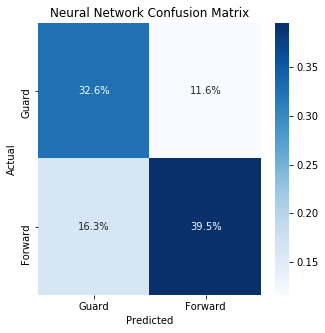

In [80]:
nn_cm = confusion_matrix(y_test, y_test_pred_nn)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(nn_cm/np.sum(nn_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Neural Network Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

In [96]:
nn_model._estimator_type = "classifier"
vc = VotingClassifier(estimators=[('ab', ab), ('nn', nn_model)], voting='soft', flatten_transform=True)
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Train f1 score', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 score', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy', accuracy_score(y_test, y_test_pred_vc))

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a47323690>, as the constructor either does not set or modifies parameter validation_data